In [1]:
from seirsplus.models import *
import networkx
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from hyperopt import hp
from functools import partial
from matplotlib import pyplot as plt
from hyperopt import fmin, tpe, space_eval

## Common Function Definitions

In [204]:
#### Since the model outputs a different format than the CSSEGISandData, we need to align them
#### which means - finding the appropriate prediction for the model for a particular date

### modelI - Time Series Prediction output by model (model.numI)
### modelT - Time Series of the model (model.tseries)
### dates  - dates in the true file that we have from CSSEGISandData - datetime object


def alignTimeSeries(modelI, modelT, dates):
#     datesS = ['3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20']
#     dates = []
#     for date in datesS:
#         dates.append(datetime.strptime(date, "%m/%d/%y"))
    finalModelPredictions = []
    count = 0
    day0 = dates[0]
    for date in dates:
        t = (date-day0).days
        #print(t)
        while(modelT[count]<=t):
            count+=1
            if(count == len(modelT)):
                print("Last prediction reached - Number of predictions less than required")
                finalModelPredictions.append(modelI[count-1])
                return finalModelPredictions
            
        diff1 = t - modelT[count-1]
        diff2 = modelT[count] - t
        if(diff1<=diff2):
            finalModelPredictions.append(modelI[count-1])
            count -=1
        else:
            finalModelPredictions.append(modelI[count])
    
    finalModelPredictions_df = pd.DataFrame()
    finalModelPredictions_df['date'] = dates 
    finalModelPredictions_df['predicted_count'] = finalModelPredictions
      
    return finalModelPredictions_df

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def populate_missing_days(df,date_col,min_date,max_date):    
    r = pd.date_range(start=min_date, end=max_date) 
    df = df.set_index(date_col).reindex(r).fillna(0.0).rename_axis(date_col).reset_index()
    return df

def reciprocal_list(input_list):
    return np.reciprocal(list(map(input_list,float)))        

def predict(region_row, infected_col_name, params,n_days, observed_time_series_df, model_type='deterministic'):
    if(model_type=='deterministic'):
        
        init_beta = params['transmission_rate'][0]
        init_sigma = 1/params['incubation_period'][0]
        init_gamma = 1/params['infectious_period'][0]
        initN = region_row['population']
        initI = region_row[infected_col_name]
        initE = region_row[infected_col_name] * 40
        initR = params['recovered_count']
        
        model = SEIRSModel(beta=init_beta, sigma=init_sigma, gamma=init_gamma, initN=initN, initI=initI)
        
        
        
        if(len(params['time_stamps'])>1):
            checkpoints = {
                't' : params['time_stamps'],
                'sigma' : reciprocal_list(params['incubation_period']), 
                'gamma' : reciprocal_list(params['infectious_period']),
                'beta' : params['transmission_rate']
            }
            
            model.run(T=n_days, checkpoints=checkpoints,verbose=True)            
        else:
            model.run(T=n_days,verbose=True)
        
    return model.tseries ,model.numI


In [34]:
#Trying out hyperOpt to check how it works - ignore this

def objective(x):
    a = x['a'] 
    b = x['b']
    print(a, b, a-b)
    return a - b

# define a search space
from hyperopt import hp
space = {'a': hp.uniform('a', -10, 10), 
         'b': hp.uniform('b', 0, 10)}

# minimize the objective over the space
best = fmin(objective, space, algo=tpe.suggest, max_evals=5)
print(space_eval(space, best))

-4.331407580413201                                   
4.807741665544606                                    
-9.139149245957807                                   
9.370781152632766                                    
9.68490464801                                                                  
-0.3141234953772347                                                            
2.40538766166277                                                               
2.2932828524697157                                                             
0.11210480919305432                                                            
9.134094376732872                                                              
8.264175312927375                                                              
0.8699190638054972                                                             
0.33587095427620284                                                            
7.2910204142834525                                              

## Top level function

In [205]:
def run(input_file, n_days, region_col, plot = False,   compute_mape=False):
    region_timeseries_df = pd.read_csv(input_file)
    observed_time_series_df = pd.read_csv(observed_ts_counts_file)
    observed_time_series_df['date'] = pd.to_datetime(observed_time_series_df['reported_date'], infer_datetime_format=True)
    all_regions_predictions = []
    
    dates_str = []
    dates_dt = []
    for i in range(n_days):
        date = (day0 + timedelta(days=i+1))
        #print(date.strftime(format='%Y-%m-%d %M:%H:%S').strip())
        dates_dt.append(date)
        dates_str.append(date.strftime(format='%Y-%m-%d %M:%H:%S').strip())
        #region_timeseries_df.insert(len(region_timeseries_df.shape[1]), str(date) , np.zeros(region_timeseries_df.shape[0]))
    
    #print(region_timeseries_df.shape)
    for index, row in region_timeseries_df.iterrows():
        #print(row.dtype)
        params['recovered_count'] = row['current_recovered_count']
        time, predicted = predict(row, day0.strftime('%Y-%m-%d %M:%H:%S'), params, n_days, observed_time_series_df, model_type)
        predicted_ts = alignTimeSeries(predicted, time, dates_dt)
        predicted_ts_transpose  = predicted_ts.transpose()
        predicted_ts_transpose.columns = predicted_ts_transpose.iloc[0].apply(lambda x: x.strftime('%Y-%m-%d %M:%H:%S').strip())
        predicted_ts_transpose = predicted_ts_transpose.drop(predicted_ts_transpose.index[0])
        
        orig_row = region_timeseries_df.iloc[index,:].to_frame().T

        new_row = pd.concat([orig_row, predicted_ts_transpose.set_index(orig_row.index)], axis=1)
        
        new_row = pd.concat([orig_row, predicted_ts_transpose.set_index(orig_row.index)], axis=1)
        
        if(compute_mape):
            
            observed_predicted_df = observed_time_series_df.merge(predicted_ts,left_on='date',right_on='date')
            mape_score = mean_absolute_percentage_error(observed_predicted_df['active_cases_count'],observed_predicted_df['predicted_count'])            
            new_row['MAPE'] = mape_score
            
        if(plot):
            prediction_vec = new_row.loc[:,dates_str].transpose()
            
            dim = len(dates_str)
            
            fig, ax = plt.subplots(figsize=(15,5))
            ax.plot(dates_dt, prediction_vec, color = '#701805', label = "SEIR")
            
            plt.xlabel("Time")
            plt.ylabel("SEIR Projections")
            plt.title(row[region_col])
            ax.legend()
            outfile = "plots/" + str(region_col) + "_SEIR_projections.png"
            plt.savefig(outfile)
            plt.show()
            
    all_regions_predictions.append(new_row)           
    #print(predicted_ts.transpose)
    return all_regions_predictions  

In [215]:
region = 'country'
input_file = "{}".format(region)+'level_timeseries.csv'
output_file = "{}".format(region)+'wise_predicted_timeseries.csv'
n_days = 4
params = {
    'time_stamps' : [1],
    'transmission_rate' : [.2],
    'infectious_period' : [14],
    'incubation_period' : [4]
}

search_space = {'beta': hp.uniform('beta', 0.1, 0.4), 
         'sigma': hp.uniform('sigma', 0.14, 0.5),
          'gamma': hp.uniform('gamma', 0.06, 0.14) }

model_type = 'deterministic'

day0 = datetime.strptime('2020-03-24',"%Y-%m-%d")
observed_ts_counts_file = "{}".format(region) + 'wise_observed_counts.csv'


t = 399.90
	 S   = 100461608.76055984
	 E   = 1069.295446326416
	 I   = 14060.418142888188
	 D_E = 0.0
	 D_I = 0.0
	 R   = 1238523261.5258505
	 F   = 0.0


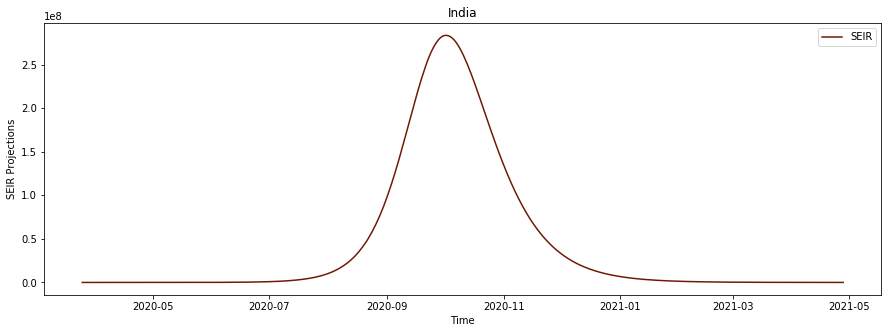

In [216]:
predtemp = run(input_file,400,region,True,True)